65.0
80.0
68.0
60.0
84.0
85.0
75.0
nan
51.0
50.0
70.0
85.0
nan
91.0
nan
51.0
nan
72.0
66.0
70.0
101.0
57.0
75.0
44.0
nan
110.0
60.0
98.0
47.0
60.0
50.0
nan
85.0
70.0
60.0
108.0
112.0
74.0
68.0
65.0
84.0
115.0
nan
nan
70.0
61.0
48.0
84.0
33.0
66.0
nan
52.0
110.0
68.0
60.0
100.0
24.0
89.0
66.0
60.0
63.0
60.0
44.0
50.0
nan
76.0
nan
72.0
47.0
81.0
95.0
69.0
74.0
85.0
60.0
21.0
nan
50.0
72.0
60.0
100.0
32.0
78.0
80.0
nan
121.0
122.0
40.0
105.0
60.0
60.0
85.0
80.0
60.0
69.0
nan
78.0
73.0
85.0
77.0
nan
77.0
64.0
94.0
nan
75.0
60.0
50.0
85.0
105.0
75.0
nan
77.0
nan
61.0
34.0
nan
74.0
90.0
65.0
nan
50.0
75.0
55.0
48.0
60.0
nan
55.0
69.0
69.0
88.0
nan
75.0
nan
78.0
80.0
nan
82.0
73.0
65.0
70.0
78.0
71.0
78.0
70.0
24.0
51.0
nan
63.0
nan
120.0
107.0
nan
nan
84.0
60.0
60.0
92.0
100.0
134.0
nan
110.0
95.0
55.0
40.0
62.0
nan
86.0
62.0
nan
nan
141.0
44.0
80.0
47.0
84.0
97.0
nan
63.0
60.0
nan
54.0
60.0
63.0
92.0
90.0
nan
60.0
64.0
41.0
70.0
nan
68.0
24.0
60.0
24.0
79.0
174.0
92.0
76.0
80.0
75.0
50.0
na

<Axes: >

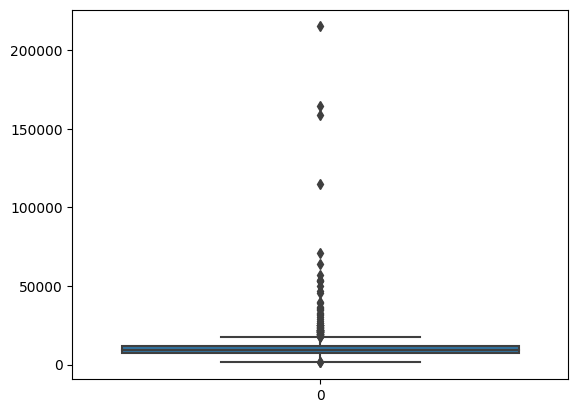

In [7]:
import pandas as pd
import numpy as np
df=pd.read_csv('/content/train.csv')
df.head()
df.columns
df=df.drop(columns=['Id'],axis=1)
df.shape
#pd.set_option('max_rows',2000)
#pd.set_option('max_columns',2000)
df.head()
for x in df['LotFrontage']:
  print(x)


import seaborn as sns
sns.boxplot(df['LotArea'])

#for x in df.columns:
  #print(df[x][0])


In [8]:

df.dtypes
#convert MSSubClass to object type as it is a categorical feature
df['MSSubClass'] = df['MSSubClass'].astype(str)
df.dtypes
df.select_dtypes(exclude='object')
#check for categorical features having null values greater than 1
cat=df.select_dtypes(include='object')
type(cat)
list=[]
for col in cat.columns:
  if cat[col].isna().sum()>0:
    list.append(col)


print(list)
print(len(list))

import seaborn as sns
#cat['Alley'].value_counts().plot(kind='bar')
#cat['Alley'].value_counts()

#segregating categorical columns with NA as special meaning,those NA should not be replaced by mode rather it should be replaced by none

for column in ['Alley','BsmtFinType2','BsmtFinType1','FireplaceQu','GarageType','GarageQual','GarageCond','PoolQC','MiscFeature','Fence','GarageFinish','BsmtQual','BsmtExposure','GarageFinish','BsmtCond']:
  df[column]=df[column].fillna("None")

for column in ['MasVnrType','Electrical']:
  df[column]=df[column].fillna(df[column].mode()[0])

#imputing numerical columns
catnumber=df.select_dtypes(exclude='object')
listnew=[]
for col in catnumber.columns:
  if catnumber[col].isnull().sum()>0:
    listnew.append(col)

#df.isnull().sum()

print(listnew)

#we will do KNN imputation for imputing values in numeric columns

from sklearn.neighbors import KNeighborsRegressor

def knnimpute(df,na_target):
  df=df.copy()
  numeric_df=df.select_dtypes(np.number)

  non_na_columns=numeric_df.loc[: ,numeric_df.isna().sum()==0].columns   #just the columns(numeric) with non missing values
  y_train=numeric_df.loc[numeric_df[na_target].isna()==False,na_target]   #basically the values in column(na_target)which are non null
  x_train=numeric_df.loc[numeric_df[na_target].isna()==False,non_na_columns]  #basicallly all the values of columns where there are no missing values corresponding to na_target
  x_test=numeric_df.loc[numeric_df[na_target].isna()==True,non_na_columns] #basically all the values where corresponding to na_target null values we have other column non null values
  knn=KNeighborsRegressor()
  knn.fit(x_train,y_train)
  y_pred=knn.predict(x_test)
  df.loc[df[na_target].isna()==True,na_target]=y_pred
  return df


#knnimpute(df,'LotFrontage') #basically this functon is returning me numeric columns in this dataframe
for column in ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']:
  df=knnimpute(df,column)


#check for null values now-
df.isnull().sum()










['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
16
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [9]:
#OUTLIER DETECTION AND REMOVAL-
#outlier can only be possible in numeric columns as categorical columns will always have values belonging to a specific category
numeric_df=df.select_dtypes(exclude='object')
numeric_df.shape


#Here we have used IQR to detect the outliers and then replace it with the values higher limit and lower limit of that particular column
#listnumeric=[]
#for col in numeric_df.columns:
  #listnumeric.append(col)


#print(listnumeric)

for column in ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']:
  Q1=df[column].quantile(0.25)
  Q3=df[column].quantile(0.75)
  IQR=Q3-Q1

  lower_lim=Q1-IQR*1.5
  higher_lim=Q3+IQR*1.5

  df[column]=np.where(df[column]>higher_lim,higher_lim,np.where(df[column]<lower_lim,lower_lim,df[column]))




<Axes: xlabel='LotArea'>

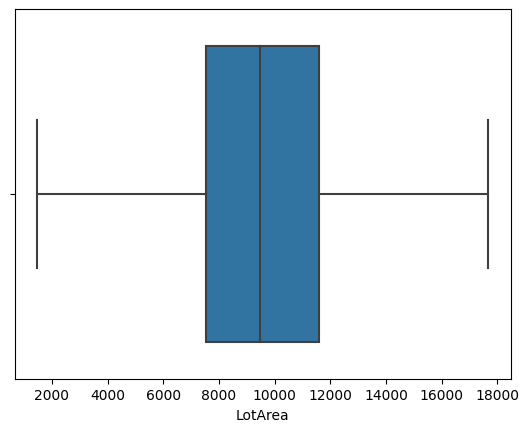

In [10]:
import seaborn as sns
sns.boxplot(x=df['LotArea'])

<Axes: xlabel='LotArea'>

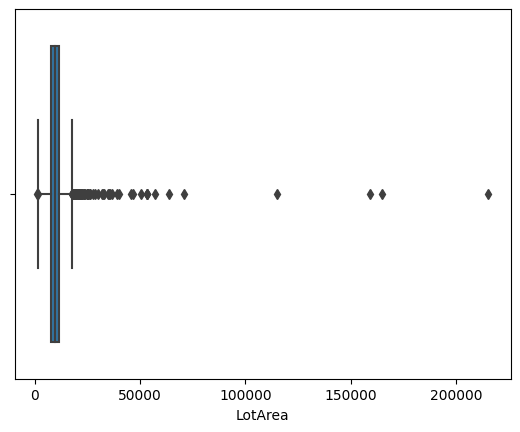

In [11]:
sns.boxplot(x=numeric_df['LotArea'])

In [12]:
#now we will convert categorical columns into numeric one through frequency encoding-

new_df=df.select_dtypes(include='object')
list=[]
for c in new_df:
  list.append(c)

#print(list)
for c in (list):
  df[c+'_freq']=df[c].map(df.groupby(c).size()/df.shape[0])

df.shape





(1460, 124)

In [13]:
df=df.drop(columns=[col for col in list],axis=1)

In [14]:
df.shape
#df['Alley_freq']

(1460, 80)

In [15]:
from sklearn.model_selection import train_test_split
Y=df['SalePrice']

In [16]:
col="SalePrice"
X = df.loc[:, df.columns != col]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
regressor=RandomForestRegressor()

from sklearn.model_selection import RandomizedSearchCV

import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [19]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [20]:
rf = RandomForestRegressor()

In [21]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42,n_jobs=1)

In [22]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   2.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   2.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   4.8s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   3.1s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   4.1s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   3.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   3.1s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   3.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=   2.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=   2.3s
[CV] END max_depth=5, max_feat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   6.9s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [23]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [24]:
rf_random.best_score_

-510284743.84050864

In [25]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=1000)

In [26]:
regressor=RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=1000)

In [27]:
regressor.fit(X_train,y_train)

RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=1000)

In [28]:
regressor.score(X_test,y_test)

0.8969496698318172

In [29]:
y_pred=regressor.predict(X_test)
from sklearn.metrics import r2_score as r2
y_pred

array([232772.5145    , 143888.219     , 123298.775     , 205966.331     ,
        94078.372     , 108411.292     , 236645.2565    , 131849.802     ,
       310349.5845    , 158653.9515    , 196867.405     , 152290.432     ,
       226218.792     , 128160.45847619, 128414.344     , 141201.99316667,
       229627.3565    , 113860.458     , 140408.63597619, 173997.2365    ,
       131197.13228571, 145939.8885    , 114677.76216667, 167531.51      ,
       193430.455     , 204378.259     , 169571.499     ,  86996.58      ,
       315051.473     , 117723.824     , 150576.0845    , 202163.38      ,
       140545.585     , 293359.055     , 307386.229     , 185386.8205    ,
       268433.0375    , 126466.58661905, 231692.618     , 299445.5445    ,
       208546.2055    , 137775.897     , 181325.4385    , 298209.353     ,
       312366.9535    , 147361.73      , 127658.06766667, 128478.531     ,
       167822.488     , 109836.344     , 318758.0615    , 146394.95416667,
       171331.7835    ,  

In [30]:
errors = abs((y_pred - y_test)/y_test)
print('Mean Relative Error:', round(np.mean(errors), 2))

Mean Relative Error: 0.09


In [31]:
from sklearn import metrics
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error (MSE): 467653118.72220105


In [32]:
test_df=pd.read_csv('/content/test.csv')

In [33]:
test_df.shape

(1459, 80)

In [35]:
test_df=test_df.drop(columns=['Id'],axis=1)
test_df.shape
#pd.set_option('max_rows',2000)
#pd.set_option('max_columns',2000)
test_df.head()

KeyError: ignored

In [36]:
test_df.isnull().sum()

MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64

In [37]:
test_df.shape

(1459, 79)

In [38]:
test_df.dtypes
test_df['MSSubClass'] = test_df['MSSubClass'].astype(str)

In [39]:
cat_new=test_df.select_dtypes(include='object')
type(cat_new)
listnew=[]
for col in cat_new.columns:
   if cat_new[col].isnull().sum()>0:
    listnew.append(col)

In [40]:
print(listnew)
print(len(listnew))

['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']
22


In [41]:
for column in ['MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType','MasVnrType']:
  test_df[column]=test_df[column].fillna(test_df[column].mode()[0])


In [42]:
for column in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
  test_df[column]=test_df[column].fillna("None")

In [43]:
test_df.isnull().sum()
listnew1=[]
catnumber1=test_df.select_dtypes(exclude='object')
for col in catnumber1.columns:
  if catnumber1[col].isnull().sum()>0:
    listnew1.append(col)

print(listnew1)
print(len(listnew1))


['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
11


In [44]:
def knnimpute(df,na_target):
  df=df.copy()
  numeric_df=df.select_dtypes(np.number)

  non_na_columns=numeric_df.loc[: ,numeric_df.isna().sum()==0].columns   #just the columns(numeric) with non missing values
  y_train=numeric_df.loc[numeric_df[na_target].isna()==False,na_target]   #basically the values in column(na_target)which are non null
  x_train=numeric_df.loc[numeric_df[na_target].isna()==False,non_na_columns]  #basicallly all the values of columns where there are no missing values corresponding to na_target
  x_test=numeric_df.loc[numeric_df[na_target].isna()==True,non_na_columns] #basically all the values where corresponding to na_target null values we have other column non null values
  knn=KNeighborsRegressor()
  knn.fit(x_train,y_train)
  y_pred=knn.predict(x_test)
  df.loc[df[na_target].isna()==True,na_target]=y_pred
  return df


#knnimpute(df,'LotFrontage') #basically this functon is returning me numeric columns in this dataframe
for column in ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']:
  test_df=knnimpute(test_df,column)


#check for null values now-
test_df.isnull().sum()


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

<Axes: xlabel='MasVnrArea'>

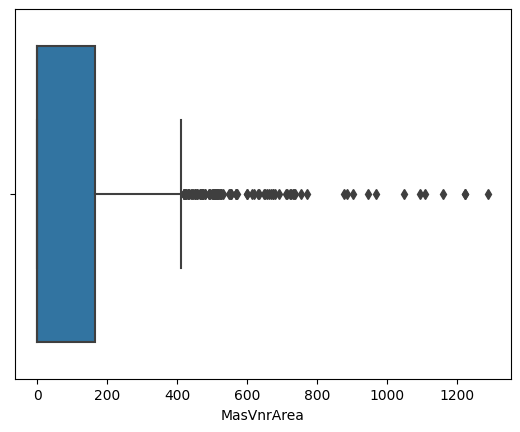

In [45]:
sns.boxplot(x=test_df['MasVnrArea'])

In [46]:
for column in ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']:
  Q1=test_df[column].quantile(0.25)
  Q3=test_df[column].quantile(0.75)
  IQR=Q3-Q1

  lower_lim=Q1-IQR*1.5
  higher_lim=Q3+IQR*1.5

  test_df[column]=np.where(test_df[column]>higher_lim,higher_lim,np.where(test_df[column]<lower_lim,lower_lim,test_df[column]))

<Axes: xlabel='MasVnrArea'>

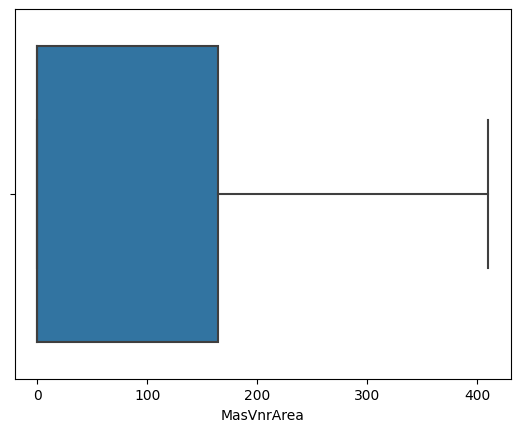

In [47]:
sns.boxplot(x=test_df['MasVnrArea'])

In [48]:
new_df1=test_df.select_dtypes(include='object')
list2=[]
for c in new_df1:
  list2.append(c)

#print(list)
for c in (list2):
  test_df[c+'_freq']=test_df[c].map(test_df.groupby(c).size()/test_df.shape[0])

test_df.shape

(1459, 123)

In [49]:
test_df=test_df.drop(columns=[col for col in list2],axis=1)


In [50]:
test_df.shape

(1459, 79)

In [51]:
y_pred_new=regressor.predict(test_df)

In [52]:
y_pred_new

array([126905.26933333, 153258.58316667, 181855.13033333, ...,
       167522.667     , 112904.115     , 232009.46      ])

In [53]:
print(len(y_pred_new))

1459


In [55]:
pred=pd.DataFrame(y_pred_new)
sub_df=pd.read_csv('/content/sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)